In [26]:
#Google Drive Access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# ✅ Install necessary packages for PyTorch stock trading agent
!pip install torch pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [22]:
# DQN Trading Agent with train_every parameter (PyTorch Version for Colab)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
from collections import deque
import matplotlib.pyplot as plt

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Utils ==========

def format_price(n):
    return ("-Rs." if n < 0 else "Rs.") + "{0:.2f}".format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_stock_data_vec(filename):
    vec = []
    with open(filename, "r") as f:
        lines = f.read().splitlines()[3:]
        for line in lines:
            price = float(line.split(",")[4])
            vec.append(price)
    return vec

def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else [-1 * data[0]] * (-d) + data[0:t + 1]
    res = [sigmoid(block[i + 1] - block[i]) for i in range(n - 1)]
    return torch.tensor([res], dtype=torch.float32).to(device)

# ========== Model ==========

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, action_size)
        )

    def forward(self, x):
        return self.net(x)

# ========== Agent ==========

class Agent:
    def __init__(self, state_size, action_size=3):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.inventory = []

        self.model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        mini_batch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in mini_batch:
            state = state.to(device)
            next_state = next_state.to(device)

            torch.set_grad_enabled(True)  # ✅ ensure gradients are on

            prediction = self.model(state)         # ✅ no torch.no_grad()
            target_val = prediction.clone()        # ✅ do NOT detach!

            if done:
                target_val[0][action] = reward
            else:
                with torch.no_grad():              # ✅ only for next Q
                    next_q_values = self.model(next_state)
                target_val[0][action] = reward + self.gamma * torch.max(next_q_values).item()

            loss = self.loss_fn(prediction, target_val)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ========== Training ==========

def train_model(stock_name="hdfc_bank_5years.csv", state_size=10, epochs=10, batch_size=32, train_every=10):
    data = get_stock_data_vec(stock_name)
    data_len = len(data) - 1
    agent = Agent(state_size=state_size)
    profit_history = []

    for e in range(epochs):
        print(f"\n--- Epoch {e + 1} ---")
        total_profit = 0
        state = get_state(data, 0, state_size + 1)
        agent.inventory = []
        step_counter = 0  # reset counter here

        for t in range(data_len):
            action = agent.act(state)
            next_state = get_state(data, t + 1, state_size + 1)
            reward = 0

            if action == 1:  # buy
                agent.inventory.append(data[t])
                print(f"Step {t}: Agent chose to BUY at {format_price(data[t])}")

            elif action == 2 and len(agent.inventory) > 0:  # sell
                bought_price = agent.inventory.pop(0)
                profit = data[t] - bought_price
                reward = profit  # Use full profit (positive or negative)
                total_profit += profit
                result = "won" if profit > 0 else "lost"
                print(f"Step {t}: Agent chose to SELL at {format_price(data[t])} | "
                      f"The agent has {result} this time with {profit:.2f} "
                      f"making Cumulative Profit: {format_price(total_profit)}")

            else:  # hold
                print(f"Step {t}: Agent chose to HOLD")

            done = t == data_len - 1
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            step_counter += 1
            if step_counter % train_every == 0:
                print(f"Training at step {step_counter}")
                agent.experience_replay(batch_size)

        print(f"Epoch {e + 1} Total Profit: {format_price(total_profit)}")
        profit_history.append(total_profit)

    # ========== Visualization ==========

    plt.figure(figsize=(12, 5))
    plt.plot(data, label="Stock Price", color="blue", alpha=0.3)
    plt.plot(profit_history, label="Cumulative Profit per Epoch", color="green", linewidth=2)
    plt.legend()
    plt.title("Trading Performance Over Epochs")
    plt.xlabel("Time")
    plt.ylabel("Price / Profit")
    plt.grid(True)
    plt.show()

    return total_profit


# Call the training function
train_model(stock_name="hdfc_bank_5years.csv", state_size=10, epochs=10, batch_size=32, train_every=10)


Streaming output truncated to the last 5000 lines.
Step 68: Agent chose to BUY at Rs.1077.77
Step 69: Agent chose to BUY at Rs.1087.12
Training at step 70
Step 70: Agent chose to HOLD
Step 71: Agent chose to HOLD
Step 72: Agent chose to HOLD
Step 73: Agent chose to BUY at Rs.1152.16
Step 74: Agent chose to SELL at Rs.1135.21 | The agent has won this time with 77.43 making Cumulative Profit: Rs.53.13
Step 75: Agent chose to HOLD
Step 76: Agent chose to SELL at Rs.1120.45 | The agent has won this time with 73.11 making Cumulative Profit: Rs.126.24
Step 77: Agent chose to SELL at Rs.1172.67 | The agent has won this time with 171.82 making Cumulative Profit: Rs.298.06
Step 78: Agent chose to SELL at Rs.1146.56 | The agent has won this time with 160.95 making Cumulative Profit: Rs.459.00
Step 79: Agent chose to HOLD
Training at step 80
Step 80: Agent chose to SELL at Rs.1177.37 | The agent has won this time with 180.36 making Cumulative Profit: Rs.639.37
Step 81: Agent chose to HOLD
Step 82

KeyboardInterrupt: 

In [27]:
import pandas as pd

def run_experiment(state_size=10, epochs=10, batch_size=32, train_every_list=[5, 10, 20], stock_name="hdfc_bank_5years.csv"):
    results = []

    for train_every in train_every_list:
        print(f"\n====== Running for train_every = {train_every} ======")

        # Call train_model for this train_every, get profits per epoch
        profit_history = train_model(stock_name=stock_name, state_size=state_size, epochs=epochs, batch_size=batch_size, train_every=train_every)

        for e, profit in enumerate(profit_history, start=1):
            print(f"Epoch {e} | train_every={train_every} | Profit: {format_price(profit)}")
            results.append({
                "train_every": train_every,
                "epoch": e,
                "profit": profit
            })

    df = pd.DataFrame(results)
    csv_path = "/content/drive/My Drive/experiment_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Experiment results saved to {csv_path}")


Streaming output truncated to the last 5000 lines.
Step 795: Agent chose to BUY at Rs.1569.37
Step 796: Agent chose to BUY at Rs.1589.47
Step 797: Agent chose to BUY at Rs.1600.30
Step 798: Agent chose to HOLD
Step 799: Agent chose to HOLD
Training at step 800
Step 800: Agent chose to HOLD
Step 801: Agent chose to BUY at Rs.1613.72
Step 802: Agent chose to BUY at Rs.1560.29
Step 803: Agent chose to HOLD
Step 804: Agent chose to HOLD
Training at step 805
Step 805: Agent chose to HOLD
Step 806: Agent chose to HOLD
Step 807: Agent chose to HOLD
Step 808: Agent chose to BUY at Rs.1496.87
Step 809: Agent chose to HOLD
Training at step 810
Step 810: Agent chose to BUY at Rs.1490.04
Step 811: Agent chose to BUY at Rs.1458.81
Step 812: Agent chose to BUY at Rs.1497.89
Step 813: Agent chose to BUY at Rs.1506.63
Step 814: Agent chose to BUY at Rs.1491.01
Training at step 815
Step 815: Agent chose to HOLD
Step 816: Agent chose to BUY at Rs.1493.06
Step 817: Agent chose to BUY at Rs.1498.92
Step 8

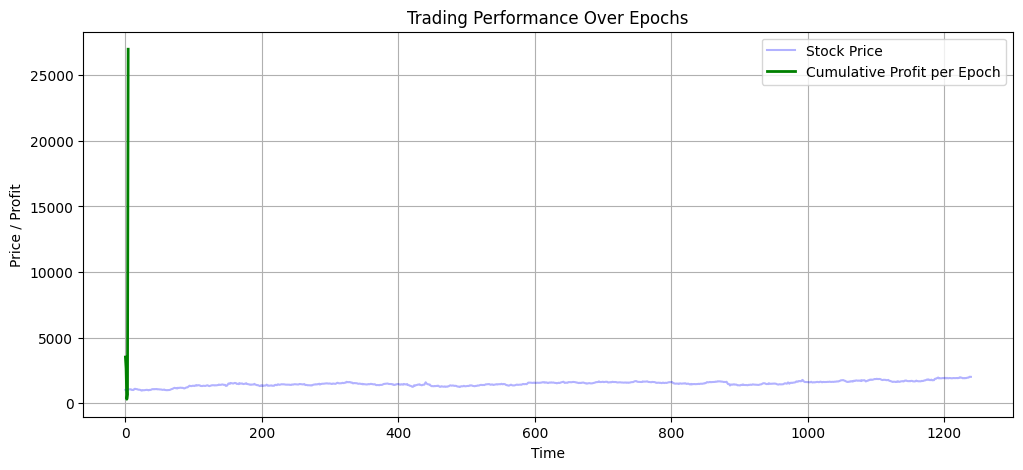

TypeError: 'float' object is not iterable

In [28]:
run_experiment(state_size=5,epochs=5,train_every_list=[5, 10, 15, 20])